In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random

vehicles = glob.glob('vehicles/**/*.png', recursive=True)
nonvehicles = glob.glob('non-vehicles/**/*.png', recursive=True)

vehicle_images = []
for path in vehicles:
    vehicle_images.append(mpimg.imread(path))

nonvehicle_images = []
for path in nonvehicles:
    nonvehicle_images.append(mpimg.imread(path))

vehicle_images_count = len(vehicle_images)
nonvehicle_images_count = len(nonvehicle_images)
print('Vehicles:', vehicle_images_count)
print('Non-vehicles:', nonvehicle_images_count)

Vehicles: 8792
Non-vehicles: 8968


In [84]:
def displayImages(images, grid, fig_size=(10,10)):
    sizex = grid[0]
    sizey = grid[1]
    fig, imtable = plt.subplots(sizey, sizex, figsize = fig_size, squeeze=False)
    for y in range(sizey):
        for x in range(sizex):
            im_idx = x + y*sizex
            im = images[im_idx]
            if len(im.shape) == 3:
                imtable[y][x].imshow(im)
            else:
                imtable[y][x].imshow(im, cmap='gray')
    plt.show()

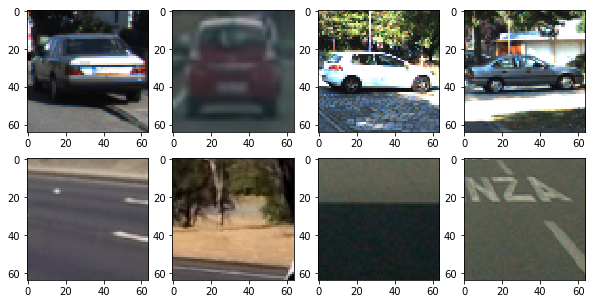

In [85]:
vehicle_nonvehicle_images = [
    vehicle_images[random.randint(0, vehicle_images_count-1)],
    vehicle_images[random.randint(0, vehicle_images_count-1)],
    vehicle_images[random.randint(0, vehicle_images_count-1)],
    vehicle_images[random.randint(0, vehicle_images_count-1)],
    
    nonvehicle_images[random.randint(0, nonvehicle_images_count-1)],
    nonvehicle_images[random.randint(0, nonvehicle_images_count-1)],
    nonvehicle_images[random.randint(0, nonvehicle_images_count-1)],
    nonvehicle_images[random.randint(0, nonvehicle_images_count-1)]
]

displayImages(vehicle_nonvehicle_images, (4,2), fig_size=(10,5))

In [86]:
from skimage.feature import hog
import math

def getHogFeatures(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=True, 
                   visualise=True, 
                   feature_vector=feature_vec)
    return features     

def getSFromHLS(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]

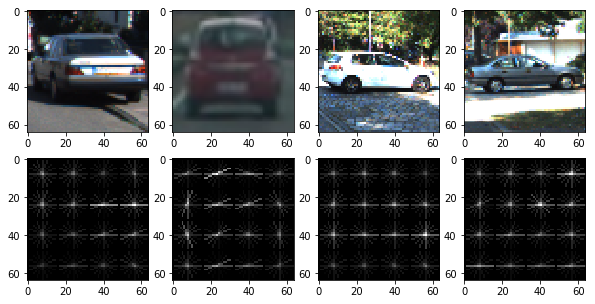

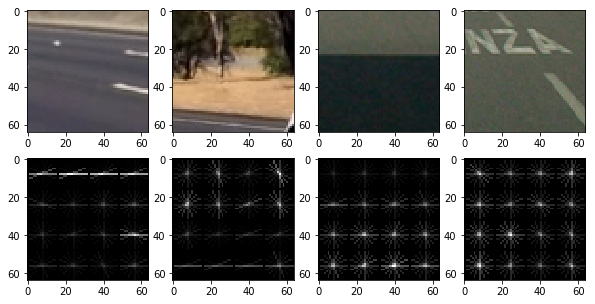

In [87]:
# Feature extraction parameters

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

vehicle_for_features = vehicle_nonvehicle_images[:4]
nonvehicle_for_features = vehicle_nonvehicle_images[4:]

feature_vehicles_examples = []
feature_vehicles_examples.extend(vehicle_for_features)

feature_nonvehicles_examples = []
feature_nonvehicles_examples.extend(nonvehicle_for_features)

for im in vehicle_for_features:
    features, hog_image = getHogFeatures(getSFromHLS(im), orient, pix_per_cell, cell_per_block)
    feature_vehicles_examples.append(hog_image)
    
for im in nonvehicle_for_features:
    features, hog_image = getHogFeatures(getSFromHLS(im), orient, pix_per_cell, cell_per_block)
    feature_nonvehicles_examples.append(hog_image)
    
displayImages(feature_vehicles_examples, (4, 2), fig_size=(10, 5))
displayImages(feature_nonvehicles_examples, (4, 2), fig_size=(10, 5))

In [88]:
def binSpatial(img, size=(32, 32)):
    ch1 = cv2.resize(img[:,:,0], size).ravel() 
    ch2 = cv2.resize(img[:,:,1], size).ravel() 
    ch3 = cv2.resize(img[:,:,2], size).ravel() 
    features = np.concatenate([ch1, ch2, ch3])
    # Return the feature vector
    return features

def colorHist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def singleImageFeatures(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = binSpatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = colorHist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features, hot_ims = getHogFeatures(feature_image, orient, pix_per_cell, cell_per_block)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extractFeatures(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = binSpatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply colorHist()
            hist_features = colorHist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features, hot_ims = getHogFeatures(feature_image, orient, pix_per_cell, cell_per_block)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def searchWindows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_AREA)      
        #4) Extract features for that window using singleImageFeatures()
        features = singleImageFeatures(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slideWindow(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    imgsizey = img.shape [0]
    imgsizex = img.shape [1]
    x_start_stop [0] = 0 if x_start_stop [0] is None else x_start_stop [0]
    x_start_stop [1] = imgsizex if x_start_stop [1] is None else x_start_stop [1]
    y_start_stop [0] = 0 if y_start_stop [0] is None else y_start_stop [0]
    y_start_stop [1] = imgsizey if y_start_stop [1] is None else y_start_stop [1]
    # Compute the span of the region to be searched
    sizex = x_start_stop [1] - x_start_stop [0]
    sizey = y_start_stop [1] - y_start_stop [0]
    # Compute the number of pixels per step in x/y
    stepx = int(xy_window [0] * xy_overlap [0])
    stepy = int(xy_window [1] * xy_overlap [1])
    # Compute the number of windows in x/y
    step_count_x = int(math.floor(1.0 * sizex / stepx)) - 1
    step_count_y = int(math.floor(1.0 * sizey / stepy)) - 1
    # Initialize a list to append window positions to
    window_list = []
    for i in range(step_count_y):
        for j in range(step_count_x):
            # Calculate each window position
            # Append window position to list
            window_list.append((
                (x_start_stop [0] + j*stepx, y_start_stop [0] + i*stepy),
                (x_start_stop [0] + j*stepx + xy_window [0], y_start_stop [0] + i*stepy + xy_window [1])))
    # Return the list of windows
    return window_list

def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [89]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

all_cars = vehicle_images
all_notcars = nonvehicle_images

car_features = extractFeatures(all_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extractFeatures(all_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [90]:
svc = SVC()
svc.fit(X_train, y_train)

# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
print('Accuracy = ', accuracy)

Accuracy =  0.9885


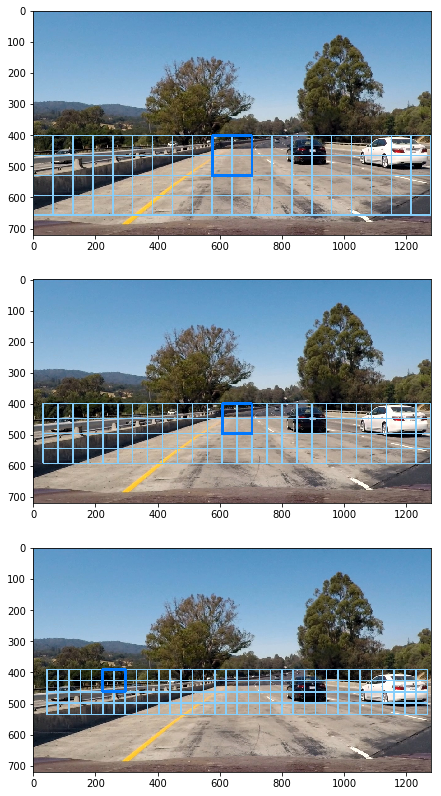

In [91]:
# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [[None, None],[32, None],[44, None]]
sw_y_limits = [[400, 656],[400, 592],[390, 534]]
sw_window_size = [(128, 128),(96, 96),(72, 72)]
sw_overlap = [(0.5, 0.5),(0.5, 0.5),(0.5, 0.5)]

# create sliding windows
size128 = slideWindow(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

size96 = slideWindow(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

size72 = slideWindow(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append(drawBoxes(np.copy(image), size128, color=(135, 206, 250), thick=4))
sliding_windows.append(drawBoxes(np.copy(image), size96, color=(135, 206, 250), thick=4))
sliding_windows.append(drawBoxes(np.copy(image), size72, color=(135, 206, 250), thick=4))

# drawing one of sliding windows in blue
sliding_windows[0] = drawBoxes(sliding_windows[0], [size128[9]], color=(0, 120, 255), thick=8)
sliding_windows[1] = drawBoxes(sliding_windows[1], [size96[12]], color=(0, 120, 255), thick=8)
sliding_windows[2] = drawBoxes(sliding_windows[2], [size72[5]], color=(0, 120, 255), thick=8)

displayImages(sliding_windows, (1, 3), fig_size=(20, 14))

In [92]:
from scipy.ndimage.measurements import label

def getHotBoxes(image):
    
    dst = np.copy(image)
    all_hot_windows = []
    
    # Iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip(sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slideWindow(
            dst,
            x_start_stop=x_limits,
            y_start_stop=y_limits, 
            xy_window=window_size,
            xy_overlap=overlap
        )

        hot_windows = searchWindows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        all_hot_windows.extend(hot_windows)

        dst = drawBoxes(dst, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, dst

def getHeatMapWithThreshold(image, bbox_list, threshold):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def calcAverageBoxes(heatmap):
    labels = label(heatmap)
    
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    
    return boxes

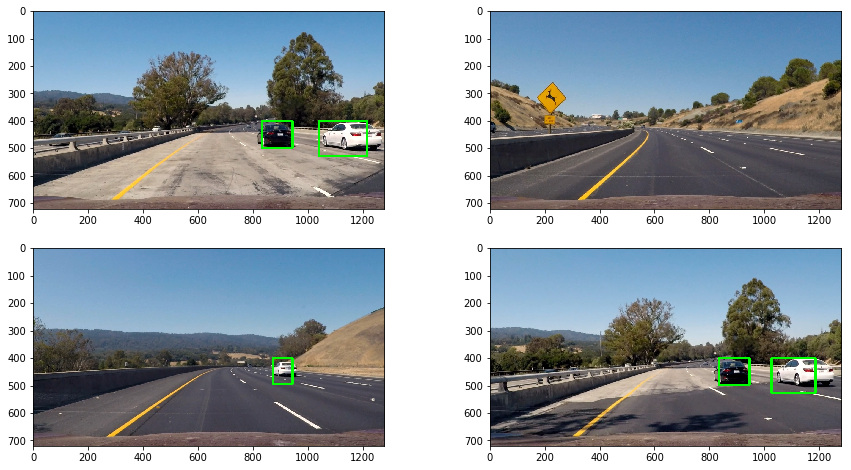

In [93]:
# Add boxes to Test images

test_images = []
result_images = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    image = image_orig.astype(np.float32)/255

    # Hot Boxes
    hot_boxes, image_with_hot_boxes = getHotBoxes(image)
    
    # Heat Map
    heat_map = getHeatMapWithThreshold(image, hot_boxes, 1)
    
    # Average Boxes
    avg_boxes = calcAverageBoxes(heat_map)
    image_with_boxes = drawBoxes(image, avg_boxes, color=(0, 1, 0), thick=8)
    
    test_images.append(image_with_hot_boxes)
    test_images.append(heat_map)
    test_images.append(image_with_boxes)
    result_images.append(image_with_boxes)

displayImages(result_images, (2, 2), fig_size=(15, 8))

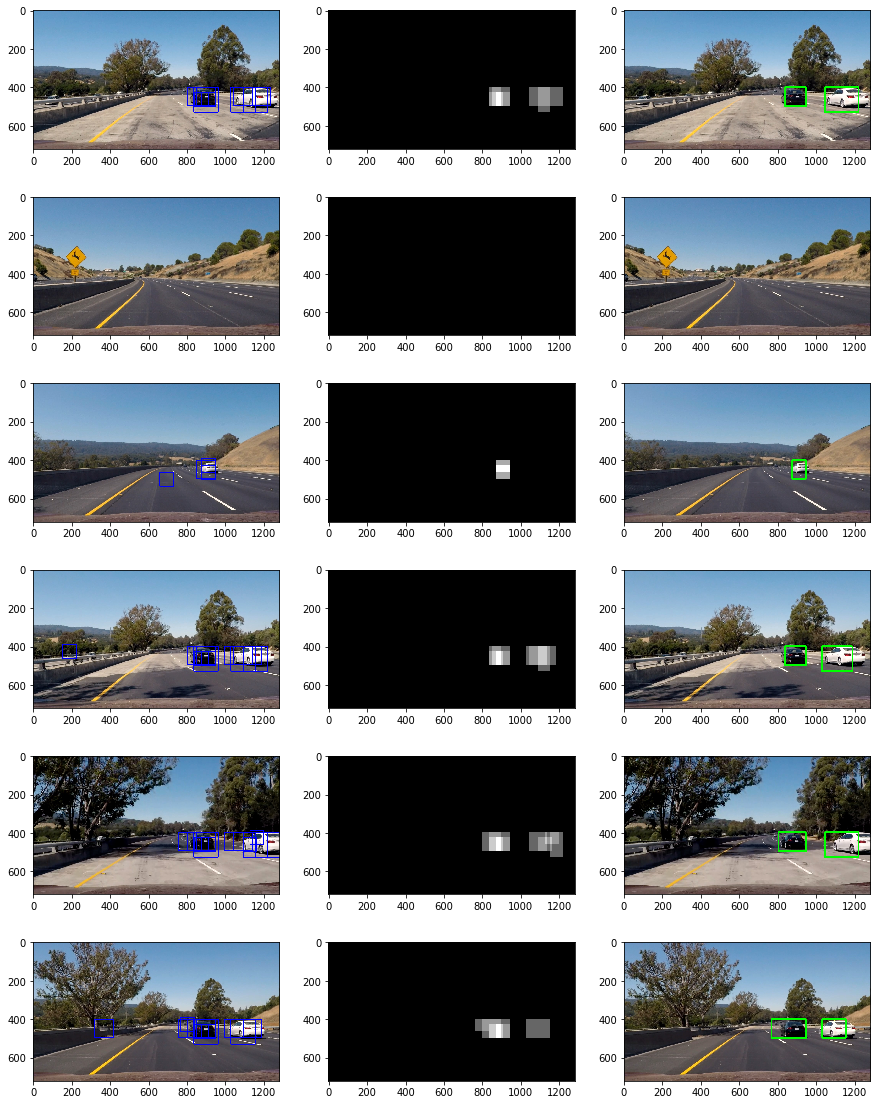

In [94]:
# Display hot boxes and heat map
displayImages(test_images, (3, 6), fig_size=(15, 20))

In [95]:
# Helper class for storing boxex from last frames

class LastHotBoxesQueue():
    def __init__(self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def putHotBoxes(self, boxes):
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop(0)
        
        self.last_boxes.append(boxes)
        
    def getHotBoxes(self):
        b = []
        for boxes in self.last_boxes:
            b.extend(boxes)
        return b
    
def processImage(image_orig):
    
    image_orig = np.copy(image_orig)
    image = image_orig.astype(np.float32)/255
    
    # Save hot boxes over last frames
    hot_boxes, image_with_hot_boxes = getHotBoxes(image)
    last_hot_boxes.putHotBoxes(hot_boxes)
    hot_boxes = last_hot_boxes.getHotBoxes()
    heat_map = getHeatMapWithThreshold(image, hot_boxes, 9)
    
    avg_boxes = calcAverageBoxes(heat_map)
    image_with_boxes = drawBoxes(image, avg_boxes, color=(0, 1, 0), thick=4)

    return image_with_boxes * 255

In [96]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

last_hot_boxes = LastHotBoxesQueue()

file_output = 'project_video_annotated.mp4'
clip = VideoFileClip('project_video.mp4')
result = clip.fl_image(processImage)
%time result.write_videofile(file_output, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [25:37<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 24min 39s, sys: 38.6 s, total: 25min 17s
Wall time: 25min 39s


In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output))